# Focus Fiduciary Check
**Author:** [Aaron Woods](https://aaronwoods.info)<br>
**Date created:** 2023/09/06<br>
**Description:** This script demonstrates how to build a binary classifier model for the task of classifying images as "In Focus" or "Out of Focus".


## Setup

In [95]:
!pip install numpy pandas matplotlib protobuf seaborn scikit-learn tensorflow > /dev/null 2>&1
# To suprress the output we use > /dev/null 2>&1

The system cannot find the path specified.


In [96]:
# Standard Libraries
import os
import sys
import random
import math
from datetime import datetime
import logging
import glob 

# Third-Party Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
from collections import defaultdict

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import TensorBoard, Callback
from keras.applications import InceptionV3, ResNet50
from keras.models import load_model
import pickle

# Type Annotations
from typing import List, Dict, Tuple, Union, Any, Optional

# Check for GPU support
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")


No GPU was detected. Neural nets can be very slow without a GPU.


In [97]:
# @title Configuration

# Configuration dictionary
config = {
    'IMG_SIZE': 224,
    'BATCH_SIZE': 16,
    'EPOCHS': 100,
    'LEARNING_RATE': 1e-3,
    'EARLY_STOPPING_PATIENCE': 5,
    'REDUCE_LR_PATIENCE': 3,
    'MIN_LR': 1e-6,
    'LOSS': "binary_crossentropy",
    'METRICS': [
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc_roc", curve="ROC"),
        AUC(name="auc_pr", curve="PR"),
    ],
    'FOCUS_THRESHOLD': 70,
    'STIG_THRESHOLD': 1,
    'LABEL_TO_INT_MAPPINGS': {
        'Focus_Label': {'InFocus': 0, 'OutOfFocus': 1},
        'StigX_Label': {'NotStiggedX': 0, 'StiggedX': 1},
        'StigY_Label': {'NotStiggedY': 0, 'StiggedY': 1}
    },
    'BASE_DIR': "C:\\Users\\User\\Desktop\\DOE_v2\\",
    'DATA_FILE': "combined_output.csv",
    'OLD_BASE_PATH': "D:\\DOE\\",
    'NEW_BASE_PATH': "C:\\Users\\User\\Desktop\\DOE_v2\\",
    'RANDOM_SEED': 42 
}


In [98]:
# Random seed for reproducibility
np.random.seed(config['RANDOM_SEED'])
tf.random.set_seed(config['RANDOM_SEED'])

## Defining the Models

In [99]:
# Transfer learning models
def create_transfer_model(base_model, input_shape: tuple, num_classes: int, hidden_units: list, dropout_rate: float, regularizer_rate: float) -> keras.Model:
    """Creates a transfer learning model based on a given base model."""
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])

    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))

    activation, units = ("sigmoid", 1) if num_classes == 2 else ("softmax", num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model

def create_mobilenetv2_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a MobileNetV2 based transfer learning model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_inceptionv3_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates an InceptionV3 based transfer learning model."""
    base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_resnet50_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a ResNet50 based transfer learning model."""
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [256, 128], 0.5, 0.001)

In [100]:
# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Determine activation and units based on the number of classes
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # Dropout and Dense output layer
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

In [101]:
# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    model = tf.keras.models.Sequential()

    # Explicitly define the input shape
    model.add(tf.keras.layers.Input(shape=input_shape))

    for _ in range(num_conv_blocks):
        model.add(tf.keras.layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(128, activation=dense_activation))

    # Determine activation and units based on the number of classes
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    model.add(tf.keras.layers.Dense(units, activation=activation))

    return model

In [104]:
# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: tuple, num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

## Load and Preprocess the data

### Functions for Preprocessing CSV Data

In [105]:
# Functions for Preprocessing CSV Data

# Function to read the data
def read_data(file_path):
    print(f"Reading data from {file_path}...")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File does not exist: {file_path}")
    try:
        data = pd.read_csv(file_path)
        print("Data read successfully.")
        return data
    except Exception as e:
        raise ValueError(f"Error reading data: {e}") from e

# Function to determine the label of an image
def get_label(row, focus_threshold, stig_threshold):
    focus_label = "InFocus" if abs(row['Focus_Offset (V)']) <= focus_threshold else "OutOfFocus"
    stig_x_label = "NotStiggedX" if abs(row['Stig_Offset_X (V)']) <= stig_threshold else "StiggedX"
    stig_y_label = "NotStiggedY" if abs(row['Stig_Offset_Y (V)']) <= stig_threshold else "StiggedY"
    return focus_label, stig_x_label, stig_y_label

# Function to update the image path
def update_image_path(row, old_base_path, new_base_path):
    image_file = row['ImageFile']
    if isinstance(image_file, str):
        # print(f"Updating image path for string: {image_file}")
        return image_file.replace(old_base_path, new_base_path)
    print(f"Encountered non-string value in 'ImageFile' column: {image_file}")
    return image_file  # or some default value, or raise an exception, etc.

# Main function for preprocessing
def preprocess_dataframe(base_dir, data_file, old_base_path, new_base_path, focus_threshold, stig_threshold):
    data_file_path = base_dir + data_file
    data = read_data(data_file_path)
    # Update image paths
    print("Updating image paths...")
    data['ImageFile'] = data.apply(update_image_path, axis=1, args=(old_base_path, new_base_path))
    # Generate labels
    print("Generating labels...")
    data['Focus_Label'], data['StigX_Label'], data['StigY_Label'] = zip(*data.apply(get_label, axis=1, args=(focus_threshold, stig_threshold)))
    return data

# # Implement the function
# labeled_df = preprocess_dataframe(base_dir="C:\\Users\\User\\Desktop\\DOE_v2\\", 
#                                data_file="combined_output.csv", 
#                                old_base_path="D:\\DOE\\", 
#                                new_base_path="C:\\Users\\User\\Desktop\\DOE_v2\\", 
#                                focus_threshold=70.0, 
#                                stig_threshold=1)

# labeled_df.head()

### Image Processing Functions

In [106]:
# Image Processing
def create_preprocessing_layers(img_width, img_height, rescale_factor):
    """Creates a Sequential model for image preprocessing."""
    return keras.Sequential([
        layers.Resizing(img_width, img_height),
        layers.Rescaling(rescale_factor)
    ])

def create_augmentation_layers(rotation_factor=0.005, height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15)):
    """Creates a Sequential model for image augmentation."""
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(rotation_factor),
        layers.experimental.preprocessing.RandomTranslation(
            height_factor=height_factor,
            width_factor=width_factor,
            fill_mode="reflect"
        )
    ])

def read_and_convert_image(file_path):
    """Reads and converts a grayscale image to RGB."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)

def preprocess_image(file_path, label, augment, preprocess_seq, augment_seq):
    """Unified function to preprocess a single image."""
    file_path = file_path.numpy().decode("utf-8")
    
    # Read and convert the image to RGB
    image = read_and_convert_image(file_path)
    
    # Apply preprocessing
    image = preprocess_seq(image)
    
    # Apply augmentation if needed
    if augment:
        image = augment_seq(image)
        
    return image, label

def preprocess_images(train_ds, valid_ds, test_ds, img_width=config['IMG_SIZE'], img_height=config['IMG_SIZE'], rescale_factor=1./255):
    """Function to preprocess and optionally augment datasets."""
    # Create preprocessing and augmentation layers
    preprocess_seq = create_preprocessing_layers(img_width, img_height, rescale_factor)
    augment_seq = create_augmentation_layers()
    
    def preprocess_wrapper(file_path, label, augment):
        image, label = tf.py_function(preprocess_image, [file_path, label, augment, preprocess_seq, augment_seq], [tf.float32, tf.int32])
        label.set_shape(())
        return image, label
    
    # Apply preprocessing and augmentation to datasets
    train_ds = train_ds.map(lambda file_path, label: preprocess_wrapper(file_path, label, augment_train=True))
    valid_ds = valid_ds.map(lambda file_path, label: preprocess_wrapper(file_path, label, augment_valid=False))
    test_ds = test_ds.map(lambda file_path, label: preprocess_wrapper(file_path, label, augment_test=False))

    return train_ds, valid_ds, test_ds

### Functions for Preparation of Data

In [107]:
# @title Data Preparation Functions

# Load multiple labels from a DataFrame
def load_data_from_dataframe_multi_labels(data_df: pd.DataFrame, label_columns: List[str]) -> Dict[str, Dict[str, int]]:
    labels_by_file_path = defaultdict(dict)
    for index, row in data_df.iterrows():
        file_path = row['ImageFile']
        labels = {label_column: row[label_column] for label_column in label_columns}
        labels_by_file_path[file_path].update(labels)
    return labels_by_file_path

# Helper Functions
def print_dataset_info(label_column: str, dataset_info: Dict[str, Dict[str, int]]) -> None:
    """Prints formatted dataset information for better readability."""
    print(f"=== {label_column} ===")
    
    for split_name, info in dataset_info[label_column].items():
        print(f"- {split_name}")
        print(f"  - Total Images: {info['Total']}")
        
        counts = ', '.join([f"{label}: {count}" for label, count in info['Counts'].items()])
        weights = ', '.join([f"{label}: {weight:.2f}" for label, weight in info['Weights'].items()])
        
        print(f"  - Counts: {counts}")
        print(f"  - Weights: {weights}")
    
    print('-' * 30)  # Print a separator for better visual distinction


def map_labels_to_integers(label: str, label_column: str) -> int:
    """Map a string label to its corresponding integer value."""
    return config['LABEL_TO_INT_MAPPINGS'][label_column].get(label, -1)


def split_and_stratify(file_paths: List[str], labels: List[str], train_size: float, val_size: float) -> Tuple[List[str], List[str], List[str], List[str], List[str], List[str]]:
    """Split dataset into training, validation, and test sets."""
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(file_paths, labels, train_size=train_size, stratify=labels)
    valid_paths, test_paths, valid_labels, test_labels = train_test_split(temp_paths, temp_labels, train_size=val_size, stratify=temp_labels)
    return train_paths, valid_paths, test_paths, train_labels, valid_labels, test_labels

def compute_weights_and_info(labels: List[str]) -> Tuple[np.ndarray, Dict[str, int], Dict[str, float]]:
    """Compute class weights and dataset information."""
    unique_labels, counts = np.unique(labels, return_counts=True)
    weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=np.array(labels))
    info = {
        'Total': len(labels),
        'Counts': dict(zip(unique_labels, counts)),
        'Weights': dict(zip(unique_labels, np.round(weights, 2)))
    }
    return weights, unique_labels, info

# Data Pipeline
def prepare_dataset(base_dir, data_file, old_base_path, new_base_path, 
                    focus_threshold, stig_threshold, label_columns, train_size=0.8, val_size=0.5):
                    
    # Step 1: Preprocess the original CSV data to get a DataFrame
    processed_data = preprocess_dataframe(base_dir, data_file, old_base_path, new_base_path, focus_threshold, stig_threshold)
    
    # Step 2: Load labels and file paths from the DataFrame
    labels_by_file_path = load_data_from_dataframe_multi_labels(processed_data, label_columns)
    file_paths = list(labels_by_file_path.keys())

    datasets, class_weights, dataset_info = {}, {}, {}

    print("Preparing data for different labels:\n")

    for label_column in label_columns:
        labels = [labels_by_file_path[file_path][label_column] for file_path in file_paths]
        train_paths, valid_paths, test_paths, train_labels, valid_labels, test_labels = split_and_stratify(file_paths, labels, train_size, val_size)

        # Compute class weights and dataset information
        train_weights, _, train_info = compute_weights_and_info(train_labels)
        valid_weights, _, valid_info = compute_weights_and_info(valid_labels)
        test_weights, _, test_info = compute_weights_and_info(test_labels)
        dataset_info[label_column] = {'Training': train_info, 'Validation': valid_info, 'Test': test_info}
        # print_dataset_info(label_column, dataset_info)


        # Map string labels to integers
        train_labels = list(map(lambda x: map_labels_to_integers(x, label_column), train_labels))
        valid_labels = list(map(lambda x: map_labels_to_integers(x, label_column), valid_labels))
        test_labels = list(map(lambda x: map_labels_to_integers(x, label_column), test_labels))


        # Create and preprocess TensorFlow datasets
        train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
        valid_ds = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))
        test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
        
        train_ds, valid_ds, test_ds = preprocess_images(train_ds, valid_ds, test_ds)
        datasets[label_column] = {'train': train_ds, 'valid': valid_ds, 'test': test_ds}
        class_weights[label_column] = {'train': train_weights, 'valid': valid_weights, 'test': test_weights}

    return datasets, class_weights, dataset_info

In [ ]:
# Calling the Data Preparation Function
datasets, class_weights, dataset_info = prepare_dataset(
    base_dir=config['BASE_DIR'],
    data_file=config['DATA_FILE'],
    old_base_path=config['OLD_BASE_PATH'],
    new_base_path=config['NEW_BASE_PATH'],
    focus_threshold=config['FOCUS_THRESHOLD'],
    stig_threshold=config['STIG_THRESHOLD'],
    label_columns=list(config['LABEL_TO_INT_MAPPINGS'].keys())
)

# # Debugging Step 1: Print 'datasets' right after calling 'prepare_dataset'
# print("\nDebugging Step 1: Structure of 'datasets' right after calling 'prepare_dataset'")
# investigate_datasets(datasets)

# # Debugging Step 2: Check for 'test' dataset specifically in each label_column
# print("\nDebugging Step 2: Checking for the presence of 'test' dataset in each label_column")
# for label_column in datasets:
#     if 'test' in datasets[label_column]:
#         print(f"'test' dataset exists in '{label_column}'")
#     else:
#         print(f"'test' dataset does NOT exist in '{label_column}'")

# # Debugging Step 3: Print 'class_weights' and 'dataset_info' for additional context
# print("\nDebugging Step 3: Printing 'class_weights' and 'dataset_info'")
# print(f"class_weights: {class_weights.keys()}")
# print(f"dataset_info: {dataset_info.keys()}")

# # Continue with the rest of your code


## Visualize the data

In [ ]:
# @title Visualize Class Weights and Data

def annotate_bars(ax, labels: list, counts: list, weights: list) -> None:
    """Annotate the bars with class weights."""
    for j, (label, count) in enumerate(zip(labels, counts)):
        ax.text(j, count, f"Weight: {weights[j]:.2f}", ha='center', va='bottom')

def plot_single_split(ax, split_data: Dict, label_column: str, split: str) -> None:
    """Plot the class counts for a single dataset split."""
    labels = list(split_data['Counts'].keys())
    counts = list(split_data['Counts'].values())
    weights = [split_data['Weights'][label] for label in labels]

    sns.barplot(x=labels, y=counts, ax=ax, palette="coolwarm")
    annotate_bars(ax, labels, counts, weights)

    ax.set_title(f"{label_column} - {split} (Total: {split_data['Total']})", fontsize=16)
    ax.set_xlabel('Labels', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.tick_params(labelsize=12)

def plot_academic_dataset_info(dataset_info: Dict) -> None:
    """Enhance the plots for a more academic/scientific look using seaborn."""
    sns.set(style="whitegrid")

    for label_column, data in dataset_info.items():
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))

        for i, (split, split_data) in enumerate(data.items()):
            plot_single_split(axs[i], split_data, label_column, split)

        plt.tight_layout()
        plt.show()

plot_academic_dataset_info(dataset_info)


## Visualize Training Batches for Multiple Labels
def show_batch(image_batch, label_batch_dict, rows=1, cols=5):
    """
    Display a batch of images in a grid format.

    Args:
    - image_batch (List[Any]): Batch of images to display.
    - label_batch_dict (Dict): Dictionary containing corresponding labels for the images for multiple tasks.
    - rows (int, optional): Number of rows in the grid. Defaults to 5.
    - cols (int, optional): Number of columns in the grid. Defaults to 5.
    """
    plt.figure(figsize=(15, 15))

    for n in range(rows * cols):
        ax = plt.subplot(rows, cols, n + 1)
        plt.imshow(image_batch[n])
        label_text = "\n".join([f"{key}: {val[n]}" for key, val in label_batch_dict.items()])
        plt.title(label_text)  # Convert labels to string just in case
        plt.axis('off')

# @title Print Batch and Label Shapes and Other Diagnostics
def print_diagnostics(image_batch, label_batch_dict):
    print(f"Image batch shape: {image_batch.shape}")
    for label, label_batch in label_batch_dict.items():
        print(f"{label} batch shape: {label_batch.shape}")

# @title Iterate Over Batches for All Labels
label_columns = ['Focus_Label', 'StigX_Label', 'StigY_Label'] #might not be needed

for label_column in label_columns:
    print(f"------ {label_column} ------")
    for image_batch, label_batch in datasets[label_column]['train'].batch(25).take(1):
        label_batch_dict = {label_column: label_batch.numpy()}
        # print_diagnostics(image_batch.numpy(), label_batch_dict)
        show_batch(image_batch.numpy(), label_batch_dict)
        break  # Show only one batch per label



## Define the Callbacks

In [110]:
# @title Constants and Helper Functions
BASE_DIR = os.path.expanduser("~")
MODELS_DIR_NAME = "models"
LOG_DIR_NAME = "logs/fit"
DEFAULT_INPUT_SHAPE = (config['IMG_SIZE'], config['IMG_SIZE'], 3)
DEFAULT_NUM_CLASSES = 2

# Model configurations
MODEL_CONFIGS = {
    'mobilenetv2': {'model_fn': create_mobilenetv2_transfer_model},
    'small_xception': {'model_fn': create_small_xception_model},
    'basic_cnn': {'model_fn': create_basic_cnn_model},
    'inceptionv3': {'model_fn': create_inceptionv3_transfer_model},
    'resnet50': {'model_fn': create_resnet50_transfer_model}
}

# Set default configurations
for config_name in MODEL_CONFIGS:
    MODEL_CONFIGS[config_name].setdefault('input_shape', DEFAULT_INPUT_SHAPE)
    MODEL_CONFIGS[config_name].setdefault('num_classes', DEFAULT_NUM_CLASSES)

# Helper Functions
def create_directory(path: str) -> None:
    """Create directory if it does not exist."""
    os.makedirs(path, exist_ok=True)

def generate_log_and_checkpoint_dirs(model_name: str, label_column: str) -> Tuple[str, str]:
    """Generate log and checkpoint directories."""
    model_dir = os.path.join(BASE_DIR, MODELS_DIR_NAME, f"{label_column}_models", f"{model_name}_models")
    create_directory(model_dir)

    log_dir = os.path.join(model_dir, LOG_DIR_NAME, f"{model_name}_{datetime.now().strftime('%Y%m%d-%I%M%S%p')}")
    create_directory(log_dir)

    checkpoint_filename = f'model-{datetime.now().strftime("%Y%m%d-%I%M%S%p")}-{{epoch:02d}}-loss{{val_loss:.2f}}-acc{{val_accuracy:.2f}}.h5'
    checkpoint_path = os.path.join(model_dir, checkpoint_filename)

    return log_dir, checkpoint_path

# Callback Definition
def define_callbacks(model_name: str, label_column: str) -> List[Callback]:
    """Define the callbacks for the training process."""
    log_dir, checkpoint_path = generate_log_and_checkpoint_dirs(model_name, label_column)

    return [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=config['EARLY_STOPPING_PATIENCE']),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.2,
                                          patience=config['REDUCE_LR_PATIENCE'],
                                          min_lr=config['MIN_LR']),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]


In [ ]:
# @title Callbacks and Model Initialization

# Initialize an empty dictionary to store callbacks
callbacks = {}
models = {}
label_columns = ['Focus_Label', 'StigX_Label', 'StigY_Label']

# Initialize models and callbacks
for model_name, model_config in MODEL_CONFIGS.items():
    # Create and compile model (assuming you've already defined select_model)
    model = select_model(
        model_name,
        model_config['input_shape'],
        model_config['num_classes']
    )

    # Compile the model (replace these placeholders with your actual optimizer, loss, and metrics)
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(config['LEARNING_RATE']),
        loss=config['LOSS'],
        metrics=config['METRICS']
    )

    # Define and store callbacks
    for label_column in label_columns:
        callbacks_key = f"{model_name}_{label_column}"
        callbacks[callbacks_key] = define_callbacks(model_name, label_column)

    # Store model
    models[model_name] = model

# Display the model summaries
for model_name, model in models.items():
    print(f"Model: {model_name}")
    model.summary()
    print("\n")


## Train the Model

In [ ]:
# @title Helper Functions

def process_history(history: Any, phase: str) -> Dict[str, Any]:
    """Helper function to process training or validation history."""
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc_roc', 'auc_pr']
    prefix = 'val_' if phase == 'validation' else ''
    return {metric: history.history.get(f"{prefix}{metric}", []) for metric in metrics}

def update_callback_keys(label_column, model_name):
    return f"{model_name}_{label_column}", f"{model_name}_{label_column}_valid", f"{model_name}_{label_column}_test"

def train_model(model: Any, train_ds: Any, valid_ds: Any, config: Dict[str, Any], train_weights_dict: Dict[int, float], callbacks: Any, initial_epoch: int = 0) -> Any:
    """Train the model and return the history."""
    return model.fit(
        train_ds.batch(config['BATCH_SIZE']).cache().prefetch(buffer_size=tf.data.AUTOTUNE),
        epochs=config['EPOCHS'],
        initial_epoch=initial_epoch,
        validation_data=valid_ds.batch(config['BATCH_SIZE']).cache().prefetch(buffer_size=tf.data.AUTOTUNE),
        class_weight=train_weights_dict,
        callbacks=callbacks
    )

def evaluate_model(model: Any, test_ds: Any, config: Dict[str, Any]) -> Any:
    """Evaluate the model on the test set and return the results."""
    return model.evaluate(test_ds.batch(config['BATCH_SIZE']))


def get_latest_checkpoint(model_dir: str) -> str:
    """Return the latest checkpoint file."""
    list_of_files = glob.glob(f'{model_dir}/*.h5')
    return None if not list_of_files else max(list_of_files, key=os.path.getctime)


In [ ]:
# @title Main Training Loop
def defaultdict_to_dict(d):
    if isinstance(d, defaultdict):
        d = {k: defaultdict_to_dict(v) for k, v in d.items()}
    return dict(d)

logging.basicConfig(level=logging.ERROR)

def train_and_evaluate_all_models(
    model_names: List[str],
    label_columns: List[str],
    datasets: Dict[str, Any],
    models: Dict[str, Any],
    config: Dict[str, Any],
    class_weights: Dict[str, Any],
    callbacks: Dict[str, Any],
    results: Optional[Dict] = None
    ):
    """
    Train and evaluate multiple machine learning models.

    Args:
        model_names (List[str]): List of model names to be trained.
        label_columns (List[str]): List of label columns for training.
        datasets (Dict[str, Any]): Dictionary containing training, validation, and test datasets.
        models (Dict[str, Any]): Dictionary containing models to be trained.
        config (Dict[str, Any]): Configuration settings for the training.
        class_weights (Dict[str, Any]): Class weights for each label column.
        callbacks (Dict[str, Any]): Callbacks for training.
        results (Optional[Dict]): Existing results dictionary to update. If None, a new one is created.
    """
    
    # Check if a saved results dictionary exists and load it
    if results is None:
        if os.path.exists('training_results.pkl'):
            with open('training_results.pkl', 'rb') as f:
                results = pickle.load(f)
        else:
            results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))

    # Main Loop
    for label_column in label_columns:
        train_weights = class_weights[label_column]['train']

        for model_name in model_names:
            model = models[model_name]
            train_ds = datasets[label_column]['train']
            valid_ds = datasets[label_column]['valid']
            test_ds = datasets[label_column]['test']

            # Get the model directory
            model_dir = os.path.join(BASE_DIR, MODELS_DIR_NAME, f"{label_column}_models", f"{model_name}_models")
            latest_checkpoint = get_latest_checkpoint(model_dir)

            initial_epoch = 0
            if latest_checkpoint:
                print(f"Resuming from {latest_checkpoint}")
                model = load_model(latest_checkpoint)
                filename = os.path.basename(latest_checkpoint)
                initial_epoch = int(filename.split("-")[3])

            print(f"Training {model_name} on train dataset for {label_column}...")

            train_weights_dict = {0: train_weights[0], 1: train_weights[1]}
            train_cb_key, valid_cb_key, test_cb_key = update_callback_keys(label_column, model_name)

            try:
                history = train_model(model, train_ds, valid_ds, config, train_weights_dict, callbacks[train_cb_key], initial_epoch=initial_epoch)

                # New way
                results[model_name][label_column]['training'] = process_history(history, 'training')
                results[model_name][label_column]['validation'] = process_history(history, 'validation')
            except KeyError as e:
                logging.error(f"KeyError: {e}. Callback or class weight for {model_name} and {label_column} not found.")
                continue

            evaluation_results = evaluate_model(model, test_ds, config)
            print(f'{model_name} on train - Test Loss: {evaluation_results[0]:.4f}, Test Accuracy: {evaluation_results[1]*100:.2f}%')
    # Save the results dictionary to a pickle file
    # Convert the results defaultdict to a regular dictionary
    results_dict = defaultdict_to_dict(results)

    # Save the results with a unique timestamp
    with open(f'training_results_{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl', 'wb') as f:
        pickle.dump(results_dict, f)


results = None  # Or initialize it with some existing data if you have any.

# Specify model names and label columns
model_names = ["mobilenetv2", "small_xception", "basic_cnn", "inceptionv3", "resnet50"]
train_and_evaluate_all_models(
    model_names,
    label_columns,
    datasets,
    models,
    config,
    class_weights,
    callbacks,
    results=results
)

Training mobilenetv2 on train dataset for Focus_Label...
Epoch 1/100


c:\Program Files\Python36\envs\AutoScript\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


563/563 [==============================] - 461s 814ms/step - loss: 1.0129 - accuracy: 0.9259 - precision: 0.7428 - recall: 0.9281 - auc_roc: 0.9747 - auc_pr: 0.8979 - val_loss: 0.4148 - val_accuracy: 0.9449 - val_precision: 0.7820 - val_recall: 0.9811 - val_auc_roc: 0.9889 - val_auc_pr: 0.9539

Epoch 00001: val_loss improved from inf to 0.41478, saving model to C:\Users\User\models\Focus_Label_models\mobilenetv2_models\model-20230829-045725PM-01-loss0.41-acc0.94.h5
Epoch 2/100
563/563 [==============================] - 275s 489ms/step - loss: 0.3356 - accuracy: 0.9348 - precision: 0.7652 - recall: 0.9434 - auc_roc: 0.9825 - auc_pr: 0.9183 - val_loss: 0.2755 - val_accuracy: 0.9289 - val_precision: 0.7292 - val_recall: 0.9906 - val_auc_roc: 0.9872 - val_auc_pr: 0.9482

Epoch 00002: val_loss improved from 0.41478 to 0.27553, saving model to C:\Users\User\models\Focus_Label_models\mobilenetv2_models\model-20230829-045725PM-02-loss0.28-acc0.93.h5
Epoch 3/100
563/563 [=======================

PicklingError: Can't pickle <function <lambda> at 0x000002A70FF46730>: attribute lookup <lambda> on __main__ failed

In [ ]:

# Function to convert defaultdict to regular dict
# def defaultdict_to_dict(d):
#     if isinstance(d, defaultdict):
#         d = {k: defaultdict_to_dict(v) for k, v in d.items()}
#     return dict(d)

# # Convert results to regular dictionary
# results_dict = defaultdict_to_dict(results)

# # Save the results with a unique timestamp
# with open(f'training_results_{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl', 'wb') as f:
#     pickle.dump(results_dict, f)

# This saving is not necessary if you use the new training loop above

In [143]:

# # Load the pickled results dictionary
# with open("training_results_20230905103528.pkl", 'rb') as f:
#     loaded_results = pickle.load(f)

# # Initialize a new dictionary to hold the restructured results
# new_results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))

# # Loop through the existing results dictionary to populate the new one
# for model_name, model_data in loaded_results.items():
#     for dataset_type, dataset_data in model_data.items():  # Loop over 'train' (and any other keys)
#         for label_column, label_data in dataset_data.items():
#             for data_type, metrics in label_data.items():  # Loop over 'training' and 'validation'
#                 new_results[model_name][label_column][data_type] = metrics

# # Convert the new_results defaultdict to a regular dictionary
# new_results_dict = defaultdict_to_dict(new_results)

# # Save the new_results dictionary to a pickle file with a unique timestamp
# with open(f'training_results_restructured_{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl', 'wb') as f:
#     pickle.dump(new_results_dict, f)

# # This restructuring is not necessary if you use the new training loop above

In [ ]:
# Search for all pickled files in the current directory
pickled_files = glob.glob("training_results_*.pkl")

# Print out the list of found files along with their sizes
print("Found pickled files:")
for i, file in enumerate(pickled_files):
    file_size = os.path.getsize(file) // 1024  # File size in KB
    print(f"{i+1}. {file} (Size: {file_size} KB)")

In [ ]:
# Loading Pickled Files

def load_results(filename):
    """Load results from a pickle file."""
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Failed to load {filename}: {e}")
        return None

from pprint import pprint
def pretty_print_structure(d, indent=0):
    """Pretty print the structure of dictionary keys."""
    for key, value in d.items():
        print('  ' * indent + str(key))
        if isinstance(value, dict):
            pretty_print_structure(value, indent+1)

filename = 'training_results_restructured_20230905111356.pkl'
loaded_results = load_results(filename)
# pretty_print_structure(loaded_results)


In [ ]:
# Creating Plots for Multiple Labels

import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from matplotlib.legend_handler import HandlerTuple

# --- Helper Functions and Classes ---

def create_save_directory(dir_name):
    """Create save directory if it doesn't exist."""
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

class HandlerTupleVertical(HandlerTuple):
    """Custom handler for vertical alignment of legend lines."""
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()
        height_y = (height / numlines)
        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)
            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)
        return leglines


# --- Plotting Setup ---

# Set Seaborn style
sns.set_style("whitegrid")

# Generate a color palette
palette = sns.color_palette("husl", len(model_names))
color_dict = {model: palette[i] for i, model in enumerate(model_names)}

# Mapping from technical to readable names
model_name_mapping = {
    "mobilenetv2": "MobileNet V2",
    "small_xception": "Small Xception",
    "basic_cnn": "Basic CNN",
    "inceptionv3": "Inception V3",
    "resnet50": "ResNet-50"
}

metric_name_mapping = {
    'loss': 'Loss',
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'auc_roc': 'AUC-ROC',
    'auc_pr': 'AUC-PR'
}


# --- Data Preprocessing ---

# Load your restructured results
results = loaded_results

# Get unique datasets (Labels in your case)
sample_model = next(iter(results.keys()))
unique_datasets = list(results[sample_model].keys())

# Initialize dictionaries to store max epochs, max losses, and min metrics per label
max_epochs_per_label = {label: 0 for label in unique_datasets}
max_loss_per_label = {label: 0 for label in unique_datasets}
min_metrics_per_label = {label: {metric: float('inf') for metric in metrics} for label in unique_datasets}

# Calculate max epochs, max losses, and min metrics per label
for model in results:
    for dataset in results[model]:
        for train_valid in results[model][dataset]:
            for metric in results[model][dataset][train_valid]:
                max_epochs_per_label[dataset] = max(max_epochs_per_label[dataset], len(results[model][dataset][train_valid][metric]))
                if metric == 'loss':
                    max_loss_per_label[dataset] = max(max_loss_per_label[dataset], max(results[model][dataset][train_valid][metric]))
                else:
                    min_metrics_per_label[dataset][metric] = min(min_metrics_per_label[dataset][metric], min(results[model][dataset][train_valid][metric]))


# --- Plotting ---

for metric in metrics:
    ylabel = metric_name_mapping[metric]
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'{ylabel} vs Epoch', fontsize=16, y=1.1)

    for idx, dataset_name in enumerate(unique_datasets):
        plt.subplot(1, len(unique_datasets), idx+1)
        
        # Plot data
        for model_name in model_names:
            if dataset_name not in results[model_name]:
                continue
            epochs = range(1, len(results[model_name][dataset_name]['training'][metric]) + 1)
            plt.plot(epochs, results[model_name][dataset_name]['training'][metric], '--', color=color_dict[model_name], label=f'{model_name_mapping[model_name]} Training')
            plt.plot(epochs, results[model_name][dataset_name]['validation'][metric], '-', color=color_dict[model_name], label=f'{model_name_mapping[model_name]} Validation')

        # Styling
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.title(dataset_name)
        plt.xlim(1, max_epochs_per_label[dataset_name])
        if metric == 'loss':
            plt.ylim(0, max_loss_per_label[dataset_name])
        else:
            plt.ylim(min_metrics_per_label[dataset_name][metric], 1)
        plt.tight_layout()

        # Create legend
        if idx == len(unique_datasets) - 1:
            handles, labels = plt.gca().get_legend_handles_labels()
            new_handles = [(handles[i], handles[i + 1]) for i in range(0, len(handles), 2)]
            plt.legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()}, loc='center left', bbox_to_anchor=(1, 0.5))


    # Save plots
    create_save_directory(os.path.expanduser('~\label_plots'))
    save_path = os.path.join(os.path.expanduser('~\label_plots'), f"{ylabel}_vs_Epoch.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [ ]:
# Creating Plots for Multiple Models

# Initialize a nested dictionary to store max epochs per label and model
max_epochs_per_model = {label: {model_name: 0 for model_name in model_names} for label in unique_datasets}

# Calculate max epochs per label and model
for model_name in model_names:
    for dataset_name in unique_datasets:
        if dataset_name in results[model_name]:
            for train_valid in results[model_name][dataset_name]:
                for metric in results[model_name][dataset_name][train_valid]:
                    max_epochs_per_model[dataset_name][model_name] = max(
                        max_epochs_per_model[dataset_name][model_name],
                        len(results[model_name][dataset_name][train_valid][metric])
                    )

# Initialize a nested dictionary to store min metrics per label and model
min_metrics_per_model = {label: {model_name: {metric: float('inf') for metric in metrics} for model_name in model_names} for label in unique_datasets}

# Calculate min metrics per label and model
for model_name in model_names:
    for dataset_name in unique_datasets:
        if dataset_name in results[model_name]:
            for train_valid in results[model_name][dataset_name]:
                for metric in results[model_name][dataset_name][train_valid]:
                    min_metrics_per_model[dataset_name][model_name][metric] = min(
                        min_metrics_per_model[dataset_name][model_name][metric],
                        min(results[model_name][dataset_name][train_valid][metric])
                    )
# --- Plotting ---

# Improve coloring using a palette for each dataset
palette = sns.color_palette("husl", len(unique_datasets))

for metric in metrics:
    ylabel = metric_name_mapping[metric]
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'{ylabel} vs Epoch', fontsize=16, y=1.1)

    for idx, model_name in enumerate(model_names):
        plt.subplot(1, len(model_names), idx+1)

        # Plot data
        for i, dataset_name in enumerate(unique_datasets):
            if dataset_name not in results[model_name]:
                continue
            epochs = range(1, len(results[model_name][dataset_name]['training'][metric]) + 1)
            color = palette[i]  # Use a unique color for each dataset
            plt.plot(epochs, results[model_name][dataset_name]['training'][metric], '--', color=color, label=f'{dataset_name} Training')
            plt.plot(epochs, results[model_name][dataset_name]['validation'][metric], '-', color=color, label=f'{dataset_name} Validation')



        # Styling
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.title(model_name_mapping[model_name])
        plt.xlim(1, max(max_epochs_per_model[dataset_name][model_name] for dataset_name in unique_datasets))  # Use the maximum epoch range across all datasets and models
        
        if metric == 'loss':
            plt.ylim(0, max(max_loss_per_label.values()))  # Use the maximum loss range across all datasets
        else:
            # Set y-axis limit based on the minimum metric value for the specific model
            plt.ylim(min(min_metrics_per_model[dataset_name][model_name][metric] for dataset_name in unique_datasets), 1)
        
        plt.tight_layout()



        # Create legend
        if idx == len(model_names) - 1:
            handles, labels = plt.gca().get_legend_handles_labels()
            new_handles = [(handles[i], handles[i + 1]) for i in range(0, len(handles), 2)]
            plt.legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()}, loc='center left', bbox_to_anchor=(1, 0.5))
        
    # Save plots
    create_save_directory(os.path.expanduser('~\model_plots'))
    save_path = os.path.join(os.path.expanduser('~\model_plots'), f"{ylabel}_vs_Epoch.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


## Evaluation Metrics

Best accuracy for mobilenetv2 in dataset focus: 0.9500
Best accuracy for small_xception in dataset focus: 0.9600
Best accuracy for basic_cnn in dataset focus: 0.9500
Best accuracy for inceptionv3 in dataset focus: 0.9600


Exception ignored in: <bound method ScopedTFGraph.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFGraph object at 0x000002A76DFA1710>>
Traceback (most recent call last):
  File "c:\Program Files\Python36\envs\AutoScript\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
AttributeError: deleter


Best accuracy for resnet50 in dataset focus: 0.9400
Best accuracy for mobilenetv2 in dataset stigx: 0.8000
Best accuracy for small_xception in dataset stigx: 0.8100
Best accuracy for basic_cnn in dataset stigx: 0.7900
Best accuracy for inceptionv3 in dataset stigx: 0.8000
Best accuracy for resnet50 in dataset stigx: 0.7500
Best accuracy for mobilenetv2 in dataset stigy: 0.7600
Best accuracy for small_xception in dataset stigy: 0.8200
Best accuracy for basic_cnn in dataset stigy: 0.7500
Best accuracy for inceptionv3 in dataset stigy: 0.8300
Best accuracy for resnet50 in dataset stigy: 0.7900


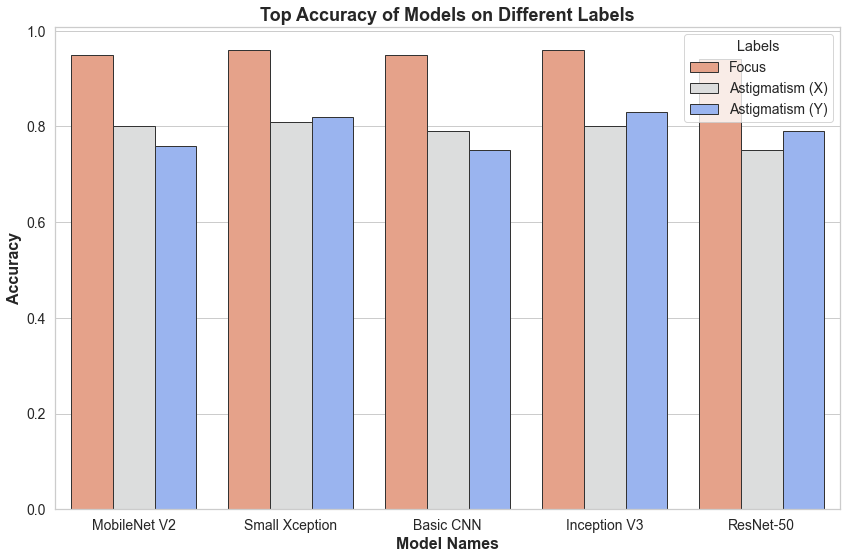

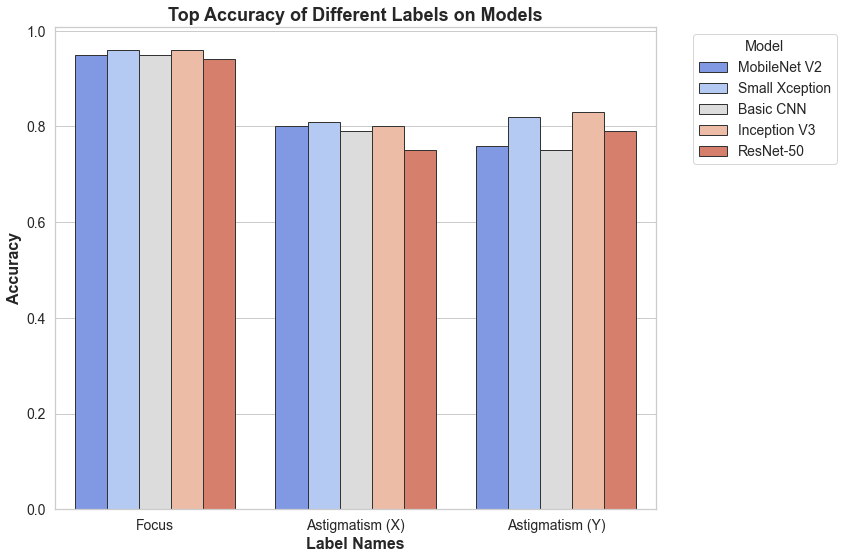

In [268]:
# Bar Charts of Best Models per Label
# Directory Configuration dictionary
dir_config = {
    'BASE_DIR': "C:/Users/User/models",
    'LABELS': ['focus', 'stigx', 'stigy'],
    'LABEL_DIR_SUFFIX': "_Label_models",
    'MODEL_DIR_SUFFIX': "_models",
}

def construct_model_dir(base_dir, label, model_name, label_dir_suffix, model_dir_suffix):
    return os.path.join(base_dir, f"{label.capitalize()}{label_dir_suffix}", f"{model_name}{model_dir_suffix}")

def select_best_model_for_name(model_name, dataset_name, models_dir):
    best_accuracy = 0.0
    best_model_path = None

    # Get the list of saved models for the current model_name
    # Instead of filtering by the dataset and model name, we simply check if it starts with "model-"
    saved_models = [file for file in os.listdir(models_dir) if file.startswith("model-")]

    # Check if there are saved models for the current model_name
    if not saved_models:
        print(f"No saved models found for {model_name} in dataset {dataset_name}.")
        return None

    # Sort the models based on the validation accuracy in the filename
    try:
        saved_models.sort(key=lambda x: float(x.split('-acc')[-1][:-3]))
    except ValueError:
        print(f"Error parsing accuracy from filename for {model_name} in dataset {dataset_name}.")
        return None

    # Select the model with the highest validation accuracy
    best_model_for_current_name = saved_models[-1]
    best_model_path = os.path.join(models_dir, best_model_for_current_name)
    best_accuracy_for_current_name = float(best_model_for_current_name.split('-acc')[-1][:-3])

    print(f"Best accuracy for {model_name} in dataset {dataset_name}: {best_accuracy_for_current_name:.4f}")
    return best_model_path


best_models = {}

for label in dir_config['LABELS']:
    for model_name in MODEL_CONFIGS.keys():  # Assuming MODEL_CONFIGS is defined elsewhere
        models_dir = construct_model_dir(
            dir_config['BASE_DIR'], label, model_name, 
            dir_config['LABEL_DIR_SUFFIX'], dir_config['MODEL_DIR_SUFFIX']
        )
        best_model_path = select_best_model_for_name(model_name, label, models_dir)

        if best_model_path:
            best_model = load_model(best_model_path)
            best_models[f"{model_name}_{label}"] = best_model


# Now you have the best models for each model name and dataset in the best_models dictionary
# Mapping from technical to readable dataset (label) names
dataset_name_mapping = {
    "focus": "Focus",
    "stigx": "Astigmatism (X)",
    "stigy": "Astigmatism (Y)"
}

# Using 'model_name_mapping' to map technical model names to readable ones
# Using 'dataset_name_mapping' to map technical dataset names to readable ones (which you called Labels)
data = []
for dataset, model_data in accuracies.items():
    data.extend(
        [model_name_mapping.get(model, model), dataset_name_mapping.get(dataset, dataset), accuracy] 
        for model, accuracy in model_data.items()
    )
df = pd.DataFrame(data, columns=['Model', 'Labels', 'Accuracy'])

# Plot with Models on the X-axis using academic-style Seaborn settings
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
palette = sns.color_palette("coolwarm_r", n_colors=len(dataset_name_mapping))
ax = sns.barplot(x='Model', y='Accuracy', hue='Labels', data=df, palette=palette, edgecolor=".2")
ax.set_title('Top Accuracy of Models on Different Labels', fontweight='bold', fontsize=18)
ax.set_xlabel('Model Names', fontweight='bold', fontsize=16)
ax.set_ylabel('Accuracy', fontweight='bold', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Labels', fontsize=14)
plt.tight_layout()
plt.show()

# Plot with Labels on the X-axis using academic-style Seaborn settings
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Labels', y='Accuracy', hue='Model', data=df, palette='coolwarm', edgecolor=".2")
ax.set_title('Top Accuracy of Different Labels on Models', fontweight='bold', fontsize=18)
ax.set_xlabel('Label Names', fontweight='bold', fontsize=16)
ax.set_ylabel('Accuracy', fontweight='bold', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.tight_layout()
plt.show()



In [269]:
# # Investigating the 'datasets' variable
# def investigate_datasets(datasets):
#     if not isinstance(datasets, dict):
#         print(f"The 'datasets' variable is not a dictionary. It is of type {type(datasets)}.")
#         return

#     print("Investigating the 'datasets' dictionary:")
    
#     # Print the keys at the root level of the dictionary
#     root_keys = list(datasets.keys())
#     print(f"Root level keys: {root_keys}")

#     # Investigate each key
#     for key in root_keys:
#         print(f"\nInspecting key: {key}")

#         # If the value for this key is also a dictionary, print its keys
#         if isinstance(datasets[key], dict):
#             sub_keys = list(datasets[key].keys())
#             print(f"  It's a dictionary with keys: {sub_keys}")
            
#             # Optionally, show the type of data for the first few items
#             for sub_key in sub_keys[:3]:
#                 sample_data = datasets[key][sub_key]
#                 print(f"    Type of data for sub_key '{sub_key}': {type(sample_data)}")
                
#                 # Deeper investigation if it's another dictionary
#                 if isinstance(sample_data, dict):
#                     deeper_keys = list(sample_data.keys())
#                     print(f"      Deeper keys in '{sub_key}': {deeper_keys}")
#                     for deeper_key in deeper_keys[:3]:
#                         print(f"        Type of data for deeper_key '{deeper_key}': {type(sample_data[deeper_key])}")

#         # If it's not a dictionary, just print the type of the value
#         else:
#             print(f"  Type of data: {type(datasets[key])}")

# # Call the function to investigate the 'datasets' variable
# investigate_datasets(datasets)


Investigating the 'datasets' dictionary:
Root level keys: ['Focus_Label', 'StigX_Label', 'StigY_Label']

Inspecting key: Focus_Label
  It's a dictionary with keys: ['train', 'valid', 'test']
    Type of data for sub_key 'train': <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
    Type of data for sub_key 'valid': <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
    Type of data for sub_key 'test': <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>

Inspecting key: StigX_Label
  It's a dictionary with keys: ['train', 'valid', 'test']
    Type of data for sub_key 'train': <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
    Type of data for sub_key 'valid': <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
    Type of data for sub_key 'test': <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>

Inspecting key: StigY_Label
  It's a dictionary with keys: ['train', 'valid', 'test']
    Type of data for sub_key 'train': <class 'ten

In [274]:
from typing import Dict, List, Any
import matplotlib.pyplot as plt
import tensorflow as tf

class PredictionPlotter:
    def __init__(self, class_names_map: Dict[str, List[str]]):
        self.class_names_map = class_names_map

    def _plot_image_subplot(self, ax, image: Any) -> None:
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    def _plot_prediction_subplot(self, ax, true_label: int, model_predictions: Dict[str, Any], class_names: List[str], index: int) -> None:
        actual_class = class_names[true_label]
        texts = [f"Actual: {actual_class}"]
        colors = ['black']

        for model_name, prediction in model_predictions.items():
            current_prediction = prediction[index]
            predicted_class = class_names[int(current_prediction > 0.5)]
            color = 'green' if actual_class == predicted_class else 'red'
            texts.append(f"{model_name}: {predicted_class}")
            colors.append(color)

        ax.axis('off')
        text_spacing = 0.1
        start_position = 1.0

        for idx, (text, color) in enumerate(zip(texts, colors)):
            ax.text(0.5, start_position - (idx * text_spacing), text, 
                    ha='center', va='center', fontsize=10, color=color, 
                    transform=ax.transAxes)

    def plot_dataset_predictions(self, images: Any, true_labels: Any, model_predictions: Dict[str, Any], dataset_name: str, class_names: List[str]) -> None:
        fig, axes = plt.subplots(2, len(images), figsize=(3 * len(images), 5))
        plt.suptitle(f"Dataset: {dataset_name}", fontsize=16, y=1.1)

        for i in range(len(images)):
            self._plot_image_subplot(axes[0, i], images[i])
            self._plot_prediction_subplot(axes[1, i], true_labels[i], model_predictions, class_names, i)

        plt.tight_layout(pad=1.0)
        plt.subplots_adjust(hspace=0.2)
        plt.show()


def evaluate_models_on_datasets(datasets: Dict[str, Any], best_models: Dict[str, Any], class_names_map: Dict[str, List[str]], batch_size: int) -> None:
    plotter = PredictionPlotter(class_names_map)
    for dataset_name, ds in datasets.items():
        test_ds = ds['test'].batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        test_images, test_labels = next(iter(test_ds))
        test_labels = test_labels.numpy()

        relevant_models = {key: model for key, model in best_models.items() if key.endswith(dataset_name)}
        predictions = {key.rsplit('_', 1)[0]: model.predict(test_images) for key, model in relevant_models.items()}

        plotter.plot_dataset_predictions(test_images, test_labels, predictions, dataset_name, class_names_map[dataset_name])



BATCH_SIZE = config['BATCH_SIZE']
class_names_map = {
    'Focus_Label': ["OutOfFocus", "InFocus"],
    'StigX_Label': ["NotStiggedX", "StiggedX"],
    'StigY_Label': ["NotStiggedY", "StiggedY"]
}
evaluate_models_on_datasets(datasets, best_models, class_names_map, BATCH_SIZE)


## In Development

In [ ]:
from typing import Dict, List, Any
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix

class PredictionPlotter:
    def __init__(self, class_names_map: Dict[str, List[str]]):
        self.class_names_map = class_names_map

    def _plot_image_subplot(self, ax, image: Any) -> None:
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    def _plot_prediction_subplot(self, ax, true_label: int, model_predictions: Dict[str, Any], class_names: List[str], index: int) -> None:
        actual_class = class_names[true_label]
        texts = [f"Actual: {actual_class}"]
        colors = ['black']

        for model_name, prediction in model_predictions.items():
            current_prediction = prediction[index]
            predicted_class = class_names[int(current_prediction > 0.5)]
            color = 'green' if actual_class == predicted_class else 'red'
            texts.append(f"{model_name}: {predicted_class}")
            colors.append(color)

        ax.axis('off')
        text_spacing = 0.1
        start_position = 1.0

        for idx, (text, color) in enumerate(zip(texts, colors)):
            ax.text(0.5, start_position - (idx * text_spacing), text, 
                    ha='center', va='center', fontsize=10, color=color, 
                    transform=ax.transAxes)

    def plot_confusion_matrix(self, ax, true_labels: np.array, predicted_labels: np.array, class_names: List[str]):
        cm = confusion_matrix(true_labels, predicted_labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=class_names, yticklabels=class_names)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title('Confusion Matrix')

    def plot_dataset_predictions(self, images: Any, true_labels: Any, model_predictions: Dict[str, Any], dataset_name: str, class_names: List[str]) -> None:
        fig, axes = plt.subplots(3, len(images), figsize=(3 * len(images), 7))
        plt.suptitle(f"Dataset: {dataset_name}", fontsize=16, y=1.1)

        for i in range(len(images)):
            self._plot_image_subplot(axes[0, i], images[i])
            self._plot_prediction_subplot(axes[1, i], true_labels[i], model_predictions, class_names, i)

        for prediction in model_predictions.values():
            predicted_labels = (prediction > 0.5).astype(int).flatten()
            self.plot_confusion_matrix(axes[2, 0], true_labels, predicted_labels, class_names)

        plt.tight_layout(pad=1.0)
        plt.subplots_adjust(hspace=0.2)
        plt.show()

def evaluate_models_on_datasets(datasets: Dict[str, Any], best_models: Dict[str, Any], class_names_map: Dict[str, List[str]], batch_size: int) -> None:
    plotter = PredictionPlotter(class_names_map)
    for dataset_name, ds in datasets.items():
        test_ds = ds['test'].batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        test_images, test_labels = next(iter(test_ds))
        test_labels = test_labels.numpy()

        relevant_models = {key: model for key, model in best_models.items() if key.endswith(dataset_name)}
        predictions = {key.rsplit('_', 1)[0]: model.predict(test_images) for key, model in relevant_models.items()}

        plotter.plot_dataset_predictions(test_images, test_labels, predictions, dataset_name, class_names_map[dataset_name])

# Assuming you have BATCH_SIZE, datasets, and best_models already defined
# BATCH_SIZE = config['BATCH_SIZE']
# evaluate_models_on_datasets(datasets, best_models, class_names_map, BATCH_SIZE)


Evaluating models on Focus_Label dataset...
Evaluating mobilenetv2_focus...


NameError: name 'batch_size' is not defined

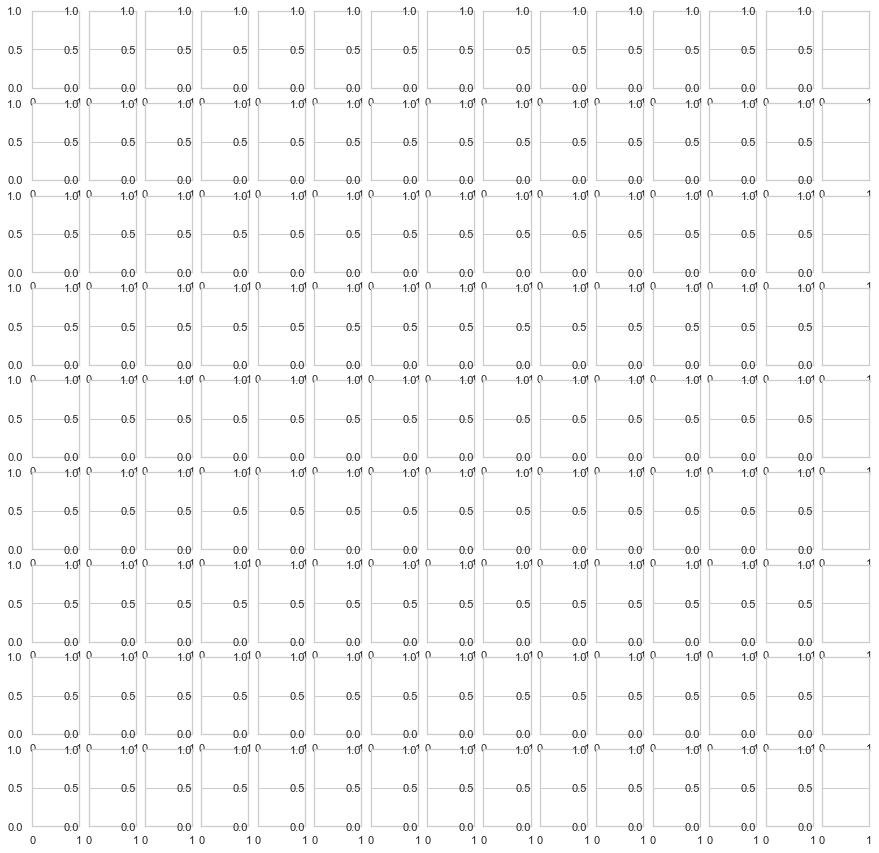

In [282]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")  # Set seaborn style

def plot_confusion_matrix(ax, y_true, y_pred, class_names):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap='Blues', cbar=False)
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names, rotation=0)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_roc_curve(ax, y_true, y_score):
    """Plot the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')

def plot_precision_recall_curve(ax, y_true, y_score):
    """Plot the Precision-Recall curve."""
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label=f'AP = {average_precision:.2f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc='upper right')

def evaluate_and_plot_metrics(ax_row, model, test_dataset, class_names):
    test_dataset = test_dataset.batch(batch_size)
    test_images, test_labels = [], []

    for images, labels in test_dataset:
        test_images.append(images)
        test_labels.append(labels)

    test_images = np.vstack(test_images)
    test_labels = np.concatenate(test_labels)

    # If the shapes look okay, proceed with evaluation
    evaluation_metrics = model.evaluate(test_dataset)
    test_loss, test_accuracy = evaluation_metrics[0], evaluation_metrics[1]
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")

    # ... (rest of your function)

    # Get predictions
    predictions = model.predict(test_images)
    y_pred = (predictions > 0.5).astype(int).flatten()
    y_score = predictions.flatten()

    # Plot metrics
    plot_confusion_matrix(ax_row[0], test_labels, y_pred, class_names)
    plot_roc_curve(ax_row[1], test_labels, y_score)
    plot_precision_recall_curve(ax_row[2], test_labels, y_score)

def main_evaluation(datasets, best_models, class_names_map):
    """Main function for evaluation."""
    # Create subplots
    num_datasets = len(datasets)
    fig, axes = plt.subplots(3 * num_datasets, len(best_models), figsize=(15, 5 * num_datasets))

    for i, (dataset_name, dataset_splits) in enumerate(datasets.items()):
        print(f"Evaluating models on {dataset_name} dataset...")
        
        # Remove '_Label' from dataset_name to match with class_names_map keys
        simplified_dataset_name = dataset_name.replace('_Label', '')
        
        class_names = class_names_map.get(simplified_dataset_name, ['Class 0', 'Class 1'])  # Default to ['Class 0', 'Class 1']

        for j, (model_name, model) in enumerate(best_models.items()):
            print(f"Evaluating {model_name}...")
            ax_row = axes[3 * i: 3 * (i + 1), j]
            
            # Use 'test' split for evaluation
            test_dataset = dataset_splits.get('test', None)
            if test_dataset is not None:
                evaluate_and_plot_metrics(ax_row, model, test_dataset, class_names)
            else:
                print(f"Test dataset not found for {dataset_name}")

    plt.tight_layout()
    plt.show()
# Run the main evaluation function
main_evaluation(datasets, best_models, class_names_map)

